### К вопросу о том, как можно искать ошибки в тексте
**Расстояние Хэмминга** - число позиций, в которых соответствующие символы двух слов одинаковой длины различны (плюс насколько второе слово длиннее первого).

**Одноклассники**<br>
Аднаклассники  H=2<br>
Одоклассники    H=10<br>
Однокласссники H=5<br>

Для **Расстояние Левенштейна** вводится три вида ошибок: вставки (*ошиббка*), удаления (*ошика*) и замены (*ашибка*).<br>
Тогда оно определяется как минимальное количество ошибок, которое надо сделать в одном слове, чтобы получить второе.

**Одноклассники**<br>
Аднаклассники  L=2<br>
Одоклассники   L=1<br>
Однокласссники L=1

**Алгоритм Библиотеки Конгресса США** основывается на том, что читатель некорректно произносит название книги на языке, который оба не понимают.
- Заменяем буквы на похожие (б-п, о-а, ...).
- Заменяем повторяющиеся буквы на одно вхождение.
- Дополнительные действия.
- Ищем (по Левенштейну).

### Тематическое моделирование

Мы уже использовали снижение размерности пространства при анализе текстов. Еще одним вариантом такого снижения является тематическое моделирование. Для него используются следующие рассуждения.

Пусть дан набор текстов, в каждом тексте имеются определенные слова. В таком случае можно посчитать матрицу термины-документы, в которой по строкам будут идти термины, по столбцам документы, а на пересечении будет стоять частота термина в данном документе. При помощи элементарных математических преобразований (метод SVD) данную матрицу можно представить в виде произведения трех матриц: матрицы слово на тематику, матрицы тематик и матрицы тематика на документ. Средняя из матриц будет квадратной и диагональной и будет содержать некоторые коэффициенты важности, которые можно отсортировать по убыванию. В этом случае размерность матрицы можно серьезно сократить, отбросив неактуальные темы.

<img  width="40%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png"> 
<img  width="40%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png">

На основе SVD работает метод латентно-семантического анализа (LSA), который позволяет более четко найти связи между терминами и документами. Его более быстрая реализация, LDA, проводит нечеткий поиск. LSI является модификацией для задач информационного поиска.

Рассмотрим теперь пример применения SVD для задач классификации.

In [3]:
import pandas as pd
import numpy as np

import pymorphy2
import re
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

# Разложение матрицы на три с сокращением размерности.
from sklearn.decomposition import TruncatedSVD

Возьмем по тысяче научных текстов из пяти разных областей науки. (Они занимают 140 Мб и не влезают на Гит, так что доступны по запросу.)

In [5]:
sci_texts = pd.read_csv("data/kaggle-science-texts_train.tsv", header=0, sep = ';')

In [6]:
%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(sci_texts['Text'])
# Проводим SVD-разложение по 20 компонентам.
svd = TruncatedSVD(n_components=20)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))
print(X2.shape, X2)

Explained variance of the SVD step: 8%
(5000, 20) [[ 0.18716104  0.05641804 -0.09602457 ... -0.04951767  0.00169427
  -0.08664436]
 [ 0.15355927 -0.00178662 -0.06001299 ... -0.00735123 -0.02260246
  -0.00110282]
 [ 0.12449795  0.0157064  -0.06641686 ... -0.03071907  0.04810986
   0.10599753]
 ...
 [ 0.27208788 -0.08811344 -0.06230206 ... -0.00221632 -0.01090925
  -0.11281363]
 [ 0.16188171 -0.07406523 -0.04232955 ... -0.00035938 -0.00621286
  -0.05964954]
 [ 0.33845172 -0.15522924 -0.07595925 ... -0.07957679 -0.00993992
  -0.06228021]]
CPU times: user 31 s, sys: 10.5 s, total: 41.6 s
Wall time: 23.4 s


Исходно, код выше выполнялся 37 минут. Но если поставить<br>
`pip install pymorphy2[fast]`<br>
то библиотека начинает работать горазо быстрее.

Если морфология работает медленно, но в тексте вссегда есть повторяющиеся слова (помните закон Ципфа?), то может быть результаты медленной морфологии надо кешировать в быстром словаре (dict)?

In [9]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [10]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 59.9 s, sys: 123 ms, total: 1min
Wall time: 1min


In [11]:
classes = np.ones(5000)
classes[1000:2000] = 2
classes[2000:3000] = 3
classes[3000:4000] = 4
classes[4000:] = 5

In [12]:
#Обучаем классификатор и оцениваем точность результатов.
X_train, X_test, y_train, y_test = train_test_split(X2, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print((len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test)))
confusion_matrix(y_test, y_hat)

/home/edward/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.966


array([[203,   0,   4,   1,   1],
       [  1, 180,   8,   1,   0],
       [  4,   1, 199,   2,   0],
       [  0,   1,   3, 186,   3],
       [  0,   0,   1,   3, 198]])

Проведем аналогичные операции, но для лемматизированных текстов.

In [13]:
%%time
X = TfidfVectorizer().fit_transform(sci_texts['NText'])
svd = TruncatedSVD(n_components=10)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


Explained variance of the SVD step: 9%
CPU times: user 14.1 s, sys: 7.15 s, total: 21.2 s
Wall time: 8.97 s


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X2, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

0.972


/home/edward/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[202,   2,   3,   0,   2],
       [  3, 183,   3,   1,   0],
       [  4,   1, 199,   2,   0],
       [  0,   1,   2, 188,   2],
       [  0,   0,   0,   2, 200]])

А тепеь посмотрим как будет работать тот же метод без SVD.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

/home/edward/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.92


array([[203,   2,   3,   0,   1],
       [  7, 160,  19,   4,   0],
       [  3,   3, 198,   1,   1],
       [  3,   2,   1, 175,  12],
       [  1,   0,   1,  16, 184]])

Для тематического моделирования текстов существует большая библиотека [BigARTM](http://bigartm.org/), но она не ставится так просто и не входит в стандартные библиотеки.

# Методы семантического анализа текстов

## Сходство между словами

You shall know a word by the company it keeps. 

*Frith*

 Варкалось. Хливкие шорьки<br>
   Пырялись по наве,<br>
   И хрюкотали зелюки,<br>
   Как мюмзики в мове.<br>

*Кэррол*

Не очень ясно что именно могут делать *зелюки*. Но если мы узнаем кто еще может *хрюкотать*, то мы можем посчитать, что нашли слово со сходным значением или, как минимум, относящееся к одной смысловой группе.

Аналогично мы не понимаем кто (что) такие *шорьки*. Если они бывают ответственными - это одно, если электронными - другое.

Модель описана в статье [Т.Миколова и др.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Идея метода основывается на оптимизации функционала, основанного на логарифмах вероятностей совместной встречаемости слов. Помимо этого, вводятся отрицательные примеры, вероятности которых не суммируются, а вычитаются. При этом отрицательных примеров берется больше, чем положительных.

- Возьмем текст и разделим его на слова, выделим слова со значимыми частями речи.
- Пройдемся по всем словам текста. Возьмем несколько соседних слов справа и слева от текущего. Посчитаем частоты их совместной встречаемости.
- Отсеем все слова, которые встречаются слишком редко или с малым количеством других слов.

In [16]:
import pandas as pd
import re
import nltk
import nltk.data
from tqdm.notebook import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/edward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [137]:
with open("data/lenta2018.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("=====\n")[1:]
    text_news = [(n.split('\n')[0], '\n'.join(n.split('\n')[2:])) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'News'])

In [138]:
news.head()

,Header,News
0,Раскрыто происхождение новейшей украинской кры...,Испытанная Украиной первая собственная крылата...
1,Русских гопников назвали настоящими древними с...,Пользователи Reddit выразили симпатию российск...
2,Поезд с американскими политиками врезался в му...,В американском штате Вирджиния пассажирский по...
3,Открыт первый европейский бордель с секс-кукла...,"Во Франции открылся первый бордель, который сд..."
4,Социологи подсчитали планирующих проголосовать...,На выборы президента собирается прийти 71 проц...


Давайте поделим тексты на предложения, а предложения на слова

In [37]:
def text_to_sentences(text):
    sentences = []
    tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
    raw_sentences = tokenizer.tokenize(text.strip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.sub('[^a-zA-Zа-яА-яёЁ]', ' ', raw_sentence).lower().split())
    return sentences

In [39]:
text_to_sentences(news['News'][1111])

[['президент',
  'украины',
  'петр',
  'порошенко',
  'на',
  'встрече',
  'с',
  'генеральным',
  'секретарем',
  'нато',
  'йенсом',
  'столтенбергом',
  'поднимет',
  'вопрос',
  'о',
  'блокировании',
  'венгрией',
  'проведения',
  'заседаний',
  'комиссии',
  'украина',
  'нато'],
 ['об',
  'этом',
  'украинским',
  'новостям',
  'рассказал',
  'посол',
  'украины',
  'при',
  'нато',
  'вадим',
  'пристайко',
  'это',
  'не',
  'первый',
  'раз',
  'когда',
  'венгрия',
  'блокирует',
  'проведение',
  'заседания',
  'комиссии',
  'украина',
  'нато',
  'на',
  'уровне',
  'министров'],
 ['и',
  'венгрия',
  'взяла',
  'это',
  'на',
  'вооружение',
  'и',
  'заявила',
  'официально',
  'что',
  'она',
  'будет',
  'блокировать',
  'все',
  'мероприятия',
  'которые',
  'проводятся',
  'уровнем',
  'выше',
  'чем',
  'уровень',
  'послов',
  'то',
  'есть',
  'мой',
  'уровень'],
 ['в',
  'этот',
  'раз',
  'жертвой',
  'стало',
  'заседание',
  'на',
  'уровне',
  'министров',

In [58]:
news['News'][0]

'Испытанная Украиной первая собственная крылатая ракета создана КБ «Луч» в рамках ОКР «Нептун» на основе российской противокорабельной ракеты 3М24 комплекса Х-35У. Об этом пишет военный блог bmpd, который ведут сотрудники московского Центра анализа стратегий и технологий.«Напомним, что в советский период серийное производство ракет 3М24 (Х-35) планировалось организовать на Харьковском авиационном заводе (нынешнее ХГАПП), так что на Украине имеется, видимо, полный комплект производственно-конструкторской документации на эту ракету, как и ведется производство ее двигателя», — отметили эксперты.Разработчиком противокорабельной ракеты 3М24 комплекса «Уран» выступает головное предприятие АО «Корпорация Тактическое ракетное вооружение» (бывшее ГНПЦ «Звезда-Стрела»), расположенное в подмосковном Королёве.Аналитики, ссылаясь на имеющиеся фото- и видеоматериалы тестов, полагают, что Украина провела бросковые испытания макета ракеты, у которого был отключен турбореактивный двигатель и отсутствов

In [90]:
all_sentences = sum([text_to_sentences(x) for x in news['News']], [])

In [52]:
all_sentences[0]

['испытанная',
 'украиной',
 'первая',
 'собственная',
 'крылатая',
 'ракета',
 'создана',
 'кб',
 'луч',
 'в',
 'рамках',
 'окр',
 'нептун',
 'на',
 'основе',
 'российской',
 'противокорабельной',
 'ракеты',
 'м',
 'комплекса',
 'х',
 'у']

## Модель Word2Vec

In [55]:
# Импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

### Использование предобученных моделей

Теперь загрузим модель, обученную разработчиками проекта <a href="http://rusvectores.org/ru/models/">RusVectores</a> для русского языка на новостях. В зависимости от того, откуда вы берете модели, они могут загружаться по-разному. Более того, модель можно обучить самому - для этого нужно просто взять много размеченных текстов.

In [56]:
model_w2v = KeyedVectors.load_word2vec_format('data/araneum_upos_skipgram_300_2_2018.vec.gz')

Теперь можно получить представление слов в новом пространстве. Имейте в виду, что в данной модели они идут с частями речи!

In [57]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [64]:
model_w2v.most_similar('интернет_NOUN')

[('интеренет_NOUN', 0.9242964386940002),
 ('интерент_NOUN', 0.915547251701355),
 ('интренет_NOUN', 0.9038119316101074),
 ('интрнет_NOUN', 0.8466424942016602),
 ('итернет_NOUN', 0.8340107202529907),
 ('интенета_NOUN', 0.8012408018112183),
 ('инетрнет_NOUN', 0.7921423316001892),
 ('интерет_NOUN', 0.786211371421814),
 ('инетернет_NOUN', 0.7794284224510193),
 ('интернт_NOUN', 0.7663599848747253)]

In [67]:
model_w2v.most_similar('ученый_NOUN')

[('исследователь_NOUN', 0.8123084902763367),
 ('биолог_NOUN', 0.7502084374427795),
 ('астрофизик_NOUN', 0.7438788414001465),
 ('ученый_ADJ', 0.7298716306686401),
 ('нейрофизиолог_NOUN', 0.7224254608154297),
 ('нейробиолог_NOUN', 0.7219529747962952),
 ('климатолог_NOUN', 0.7159755825996399),
 ('зоолог_NOUN', 0.7055575251579285),
 ('астроном_NOUN', 0.700603723526001),
 ('палеонтолог_NOUN', 0.6994453072547913)]

В пространстве Word2Vec возможны векторные операции. Попробуем их.

In [41]:
#model_w2v.most_similar(positive=[u'пожар_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN'], negative=[u'пламя_NOUN' ])
#model_w2v.most_similar(positive=[u'топливо_NOUN', u'молоко_NOUN'], negative=[u'нефть_NOUN' ])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
#model_w2v.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_w2v.most_similar(positive=[u'президент_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_w2v.most_similar(negative=[u'король_NOUN', u'мужчина_NOUN'], positive=[u'женщина_NOUN'])
model_w2v.most_similar(positive=[u'король_NOUN', u'мужчина_NOUN'], negative=[u'женщина_NOUN'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'король_NOUN' ])
#model_w2v.most_similar(positive=[u'берлин_PROPN', u'москва_PROPN' ], negative=[u'германия_PROPN'])


[('герцог_NOUN', 0.6813842058181763),
 ('генрих_PROPN', 0.6485271453857422),
 ('принц_NOUN', 0.6471316814422607),
 ('ярл_NOUN', 0.6370108127593994),
 ('конунг_NOUN', 0.6279963254928589),
 ('людовик_PROPN', 0.6209453344345093),
 ('монарх_NOUN', 0.617782711982727),
 ('кронпринц_NOUN', 0.611383318901062),
 ('сюзерен_NOUN', 0.6070358753204346),
 ('рыцарь_NOUN', 0.6002137064933777)]

Можно найти лишнее слово в последовательности.

In [68]:
model_w2v.doesnt_match(['лук_NOUN', 'перец_NOUN', 'ученик_NOUN', 'плодовый_ADJF'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'ученик_NOUN'

Итак, вместо самих слов мы можем использовать их векторные представления в некотором семантическом пространстве.

<img src="img/cartoon-espresso-word2vec.jpg">

Беда Word2Vec состоит в том, что он генерирует только один вектор на каждое слово. То есть он не различает различных смыслов одного слова.

<img src="img/cartoon-citizen-data-scientist.jpg">

Можно провести аналогию с SVD. У нас строится некоторое пространство, размерность которого определяется числом латентных переменных в системе - скрытых параметров, каждый из которых отвечает за какой-то "смысл": размер, цвет, политика, время, абстрактность, падеж слова и прочее.

Количество признаков в этом пространстве определяется числом подобных скрытых переменных.

В полученном пространстве работают векторные операции. Если обучиться на достаточно большом количестве текстов, можно получить следующие эффекты.

![](img/w2v_vect.png)

![](img/w2v_vect2.png)



На хорошо обученной модели можно даже превратить индекс в город и наоборот при помощи векторных операций.

Давайте посмотрим на реальное расположение слов в этом пространстве. Для этого нам потребуется UMAP, а то как еще мы преобразуем 300-мерное пространство в плоскость?

In [80]:
from umap import UMAP
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [70]:
trees = pd.read_csv("data/trees.txt", sep='\t', names=['trees'])
herbs = pd.read_csv("data/herbs.txt", sep='\t', names=['herbs'])
trees = trees['trees'].str.lower().unique()
herbs = herbs['herbs'].str.lower().unique()

In [77]:
men_avg, women_avg = np.zeros(model_w2v.vector_size), np.zeros(model_w2v.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    if m.strip().lower()+'_NOUN' in model_w2v.vocab.keys():
        mv = model_w2v[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
        
for w in herbs:
    if w.strip().lower()+'_NOUN' in model_w2v.vocab.keys():
        wv = model_w2v[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)

        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if c>0.6])

[(['клен', 'маргаритка'], 0.6117089698392721), (['клен', 'настурция'], 0.6115848257569042), (['клен', 'дельфиниум'], 0.6010003968890965), (['черешня', 'щавель'], 0.6182821208457462), (['черешня', 'редис'], 0.6446437627648164), (['самшит', 'настурция'], 0.6133552135715983), (['сосна', 'настурция'], 0.6001034566353993)]


In [78]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

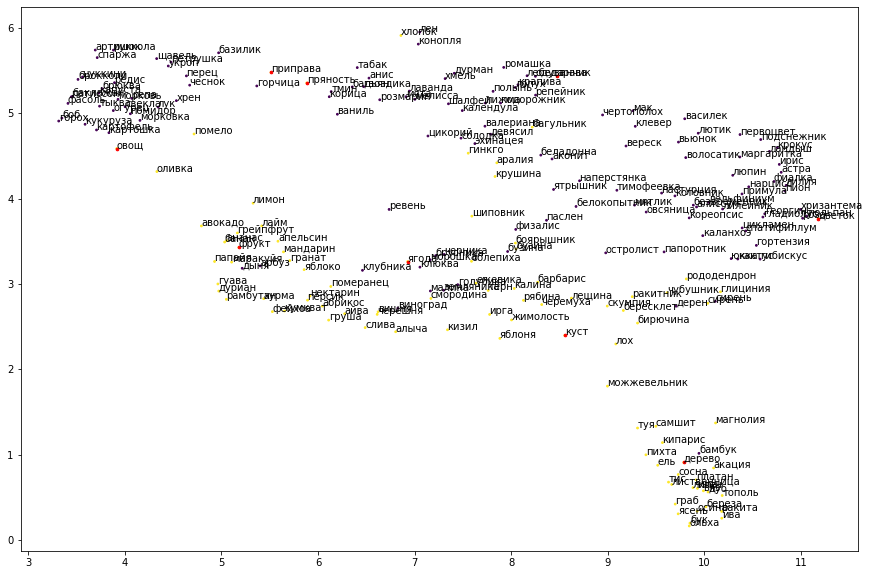

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

А теперь давайте добавим ещё одно измерение и посмотрим, как точки будут меняться вдоль него.

In [82]:
from ipywidgets import interact, FloatSlider

In [85]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP(n_components=3).fit_transform(all_vect)

In [83]:
def drawHerbs(val):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    temp_data = np.array([u for u in umaped_vct if u[2]>=val-0.5 and u[2]<=val+0.5])
    temp_names = [all_names[i] for i, u in enumerate(umaped_vct) if u[2]>=val-0.5 and u[2]<=val+0.5]
    
    ax.scatter(temp_data[:, 0], temp_data[:, 1], c=temp_data[:, 2], s=30)

    for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
        ind = all_names.index(word)
        ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)
        ax.annotate(word, (umaped_vct[ind, 0], umaped_vct[ind, 1]))

    for n, v in zip(temp_names, temp_data):
        ax.annotate(n, (v[0], v[1]))

    plt.show()

In [88]:
sld1 = FloatSlider(value=(min(umaped_vct[:, 2])+max(umaped_vct[:, 2]))/2, min=min(umaped_vct[:, 2]), max=max(umaped_vct[:, 2]), step=0.1, description='Filter by Z')

interact(drawHerbs, val=sld1);

interactive(children=(FloatSlider(value=8.921333312988281, description='Filter by Z', max=10.042521476745605, …

### Обучение собственной модели в Word2Vec


In [87]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_news = Word2Vec(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 5.55 s, sys: 48.1 ms, total: 5.6 s
Wall time: 3.03 s


Возьмем по тысяче научных текстов из пяти разных областей науки.

In [107]:
sci_sentences = []
for text in tqdm(sci_texts.Text):
#     sci_sentences.extend(normalizePymorphy(text))
    sci_sentences.append(normalizePymorphy(text))

In [108]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 50  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 4     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_sci = Word2Vec(sci_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 1min 51s, sys: 277 ms, total: 1min 52s
Wall time: 36.5 s


In [109]:
# Финализируем нашу модель. Ее нельзя будет доучить теперь, но она начнет занимать гораздо меньше места
model_our_sci.init_sims(replace=True)

In [112]:
# Посмотрим на самые похожие слова.
model_our_sci.most_similar('продукт_NOUN'), model_our_sci.most_similar('система_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


([('медиапродукт_NOUN', 0.6279958486557007),
  ('продукция_NOUN', 0.6220911145210266),
  ('медиаконтент_NOUN', 0.5835717916488647),
  ('жир_NOUN', 0.5635839104652405),
  ('неферментировать_ADJ', 0.5604872703552246),
  ('увлажнитель_NOUN', 0.557173490524292),
  ('сырьё_NOUN', 0.5483084321022034),
  ('концентрат_NOUN', 0.5458888411521912),
  ('сбалансированный_ADJ', 0.5453544855117798),
  ('поликапроамид_NOUN', 0.5403720140457153)],
 [('подсистема_NOUN', 0.7375593781471252),
  ('непрерывный_ADJ', 0.6706982254981995),
  ('взаимозависимый_ADJ', 0.647849440574646),
  ('взаимосвязанный_ADJ', 0.6406020522117615),
  ('единый_ADJ', 0.6369045376777649),
  ('интегрировать_ADJ', 0.6139225363731384),
  ('структура_NOUN', 0.6093593239784241),
  ('целостность_NOUN', 0.6079927086830139),
  ('согласовать_ADJ', 0.5923155546188354),
  ('пространство_NOUN', 0.5890568494796753)])

In [114]:
model_our_sci.most_similar('говорить_VERB')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('видеть_VERB', 0.8292636871337891),
 ('казаться_VERB', 0.7697285413742065),
 ('пытаться_VERB', 0.760887086391449),
 ('думать_VERB', 0.7598153352737427),
 ('понимать_VERB', 0.7464786767959595),
 ('знать_VERB', 0.7342994213104248),
 ('убедить_ADJ', 0.7264123558998108),
 ('объяснять_VERB', 0.707293689250946),
 ('никакой_ADJ', 0.7042993903160095),
 ('хотеть_VERB', 0.7000933885574341)]

In [115]:
model_our_sci.most_similar('ученик_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('учитель_NOUN', 0.8085069060325623),
 ('воспитатель_NOUN', 0.7672528624534607),
 ('ребята_NOUN', 0.7622626423835754),
 ('учиться_VERB', 0.742069661617279),
 ('учиться_ADJ', 0.7374716997146606),
 ('мастерская_NOUN', 0.736074686050415),
 ('педагог_NOUN', 0.735409677028656),
 ('учить_VERB', 0.7334123849868774),
 ('родитель_NOUN', 0.7137190103530884),
 ('отвлекать_VERB', 0.6973546743392944)]

In [116]:
model_our_sci.most_similar('орех_NOUN')

/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('грецкий_ADJ', 0.9072677493095398),
 ('перец_NOUN', 0.8967386484146118),
 ('крапива_NOUN', 0.8889986872673035),
 ('кориандр_NOUN', 0.8846496939659119),
 ('лук_NOUN', 0.8805913925170898),
 ('морковь_NOUN', 0.8764684796333313),
 ('чеснок_NOUN', 0.8748019933700562),
 ('горошек_NOUN', 0.8746211528778076),
 ('петрушка_NOUN', 0.8712217807769775),
 ('репчатый_ADJ', 0.8688658475875854)]

Можно найти лишнее слово в последовательности.

In [118]:
# Размер проанализированного корпуса
model_our_sci.corpus_total_words

7354828

Теперь вернемся к размеру векторов.

In [119]:
model_our_sci.vector_size

50

Посмотрим как будут отображаться растения на новой модели.

In [129]:
men_avg, women_avg = np.zeros(model_our_sci.vector_size), np.zeros(model_our_sci.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    try:
        mv = model_our_sci[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
    except:
        pass
        
for w in herbs:
    try:
        wv = model_our_sci[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)
    except:
        pass
        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if abs(c)<0.001])

[(['липа', 'бузина'], -0.0003310888364702631), (['лох', 'мелисса'], -0.0005455627314842221), (['лох', 'петрушка'], -0.0007386465019123857), (['ананас', 'кукуруза'], -0.0001696549631345718), (['лимон', 'ирис'], 0.0009405150289785275)]


/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/edward/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [130]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

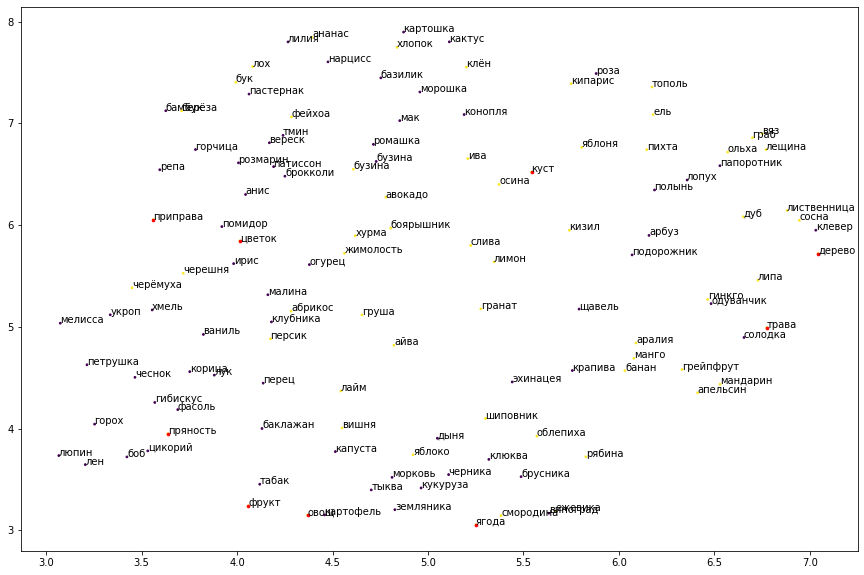

In [131]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

----

Переразметим наши тексты так, чтобы они содержали в себе и часть речи, понятную загруженной модели.

In [45]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

Теперь посмотрим какова размерность векторов, хранимых в модели, и сколько в ней слов.<br>
Размерность векторов 300 - с запасом. Почти 250 000 слов - тоже очень хорошо.

In [132]:
print(model_w2v.vector_size)
print(len(model_w2v.index2word))

300
196620


In [133]:
model_w2v.index2word[:50]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN',
 'вопрос_NOUN',
 'хороший_ADJ',
 'должный_ADJ',
 'вид_NOUN',
 'город_NOUN',
 'сайт_NOUN',
 'случай_NOUN',
 'дело_NOUN',
 'дом_NOUN',
 'сделать_VERB',
 'давать_VERB',
 'говорить_VERB',
 'россия_PROPN',
 'возможность_NOUN',
 'высокий_ADJ',
 'страна_NOUN',
 'область_NOUN',
 'мир_NOUN',
 'работать_VERB',
 'данный_ADJ',
 'начинать_VERB',
 'часть_NOUN',
 'качество_NOUN',
 'знать_VERB',
 'сказать_VERB',
 'позволять_VERB',
 'хорошо_ADV',
 'хотеть_VERB',
 'нужно_ADV',
 'принимать_VERB']

У нас есть смысл отдельных слов. Построим на его основе смысл текста как среднее арифметическое всех векторов для слов, составляющих данный текст.

In [140]:
index2word_set = set(model_w2v.index2word)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


Рассчитаем вектора всех текстов - они нам еще пригодятся.

In [141]:
w2v_vectors = [text_to_vec(text) for text in news.News]

Найдем текст, самый похожий на некоторый текст.

In [145]:
vpos = 2
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-w2v_vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
print(ms, news.News[vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

1327 В американском штате Вирджиния пассажирский поезд с членами Конгресса США от Республиканской партии столкнулся с мусоровозом. Об этом сообщает NBC News.В результате инцидента погиб один человек, еще один получил серьезные травмы. Оба находились в грузовике. Среди политиков и сопровождающего их персонала пострадавших нет.Ехавший вместе с женой и сыном в одном из передних вагонов сенатор от штата Аризона Джефф Флейк рассказал журналистам, что почувствовал сильный удар, после чего побежал оказывать помощь раненому. Он уточнил, что после столкновения первый вагон состава сошел с рельсов.Президента США Дональда Трампа информировали о происшествии.18 декабря поезд, ехавший из Портленда в Сиэтл, на скорости около 130 километров в час упал с моста на шоссе. В результате пострадали 77 человек, падающие вагоны повредили несколько легковых автомобилей и грузовиков.14 декабря на юге Франции скоростная электричка протаранила школьный автобус, пересекавший железнодорожный переезд. От сильнейшег

Теперь посмотрим как разспределятся тексты в новом пространстве.

In [146]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(w2v_vectors)

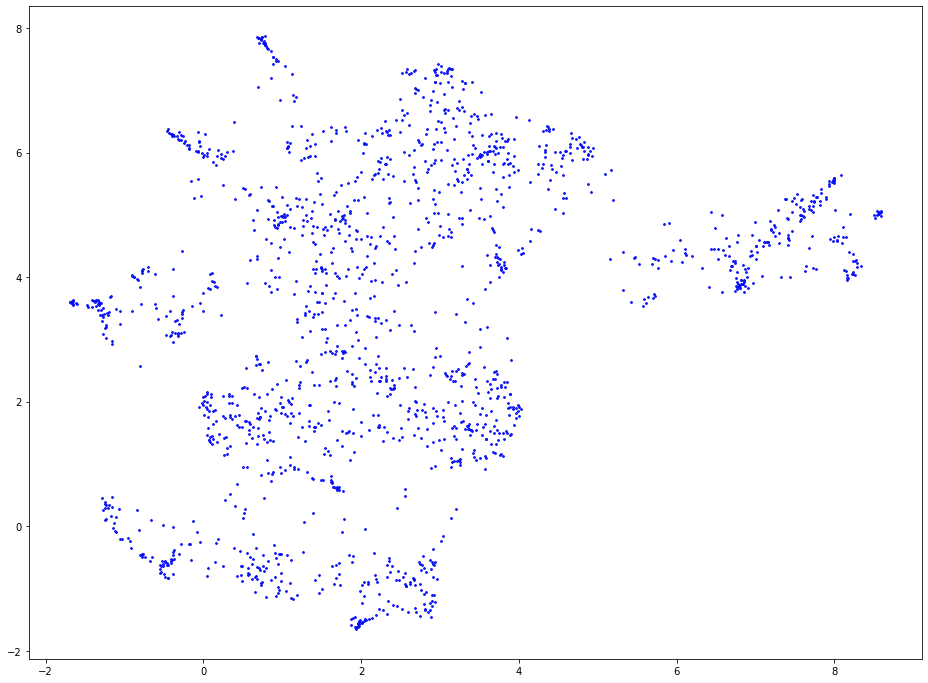

In [147]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [148]:
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice

Посмотрим что будет, если обучить на данных после преобразования пространства.

120


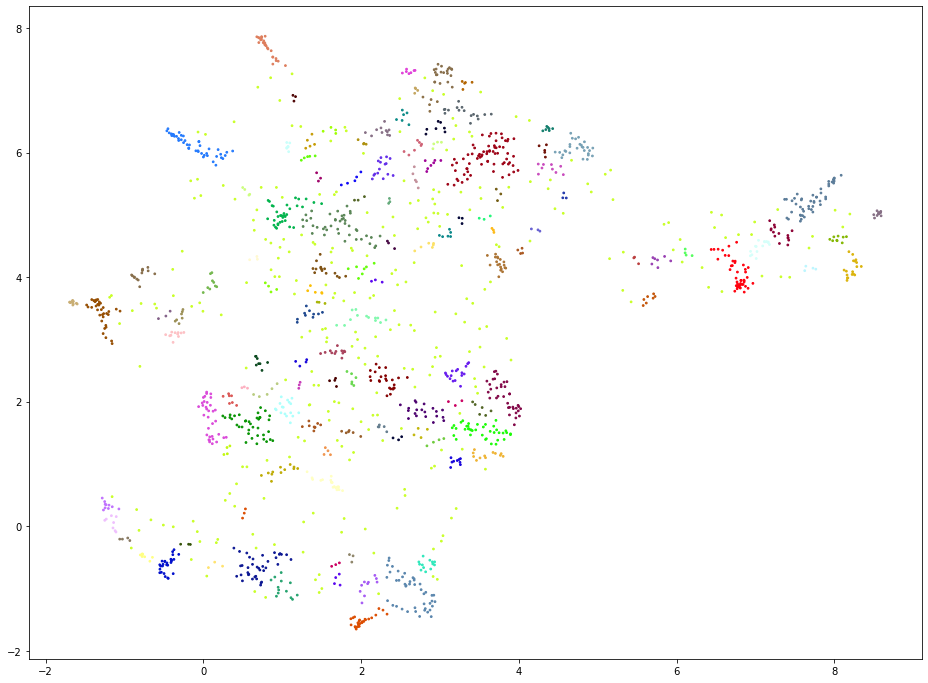

In [149]:
db=DBSCAN(eps=0.12, min_samples=3)
db_clusters=db.fit_predict(umaped_vct)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()


In [150]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
Раскрыто происхождение новейшей украинской крылатой ракеты
Китай испытал убийцу американских авианосцев
Американский «Морской охотник» попал на видео
1
Русских гопников назвали настоящими древними славянами
Ушастый лисенок из России стал мировой знаменитостью
Ставший мемом дед Гарольд привязал к стулу доминирующую начальницу
2
Поезд с американскими политиками врезался в мусоровоз
Девушка наклонилась и погибла от удара поезда в московском метро
Рабочий показал последствия падения на раскаленный асфальт
3
Открыт первый европейский бордель с секс-куклами вместо проституток
Самый богатый китаец признал бесполезность денег
У зятя президента Туркмении нашли часы на миллион долларов
4
Социологи подсчитали планирующих проголосовать на выборах-2018
Резервный фонд России официально перестал существовать
У Илона Маска кончились огнеметы
5
Названа причина исчезновения рыболовецкого судна «Восток»
Полный самолет сантехников вернулся в аэропорт из-за сломанного туалета
Путешественников из Нового У

Попробуем теперь провести кластеризацию в исходном пространстве.

Предварительно прикинем значение $\epsilon$ по расстоянию до ближайших соседей. Для этого используем функцию для построения графа k ближайших соседей из sklearn.

In [151]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

In [152]:
# Строит разреженный граф, в котором на месте связей с ближайшими соседями стоят единицы.
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)

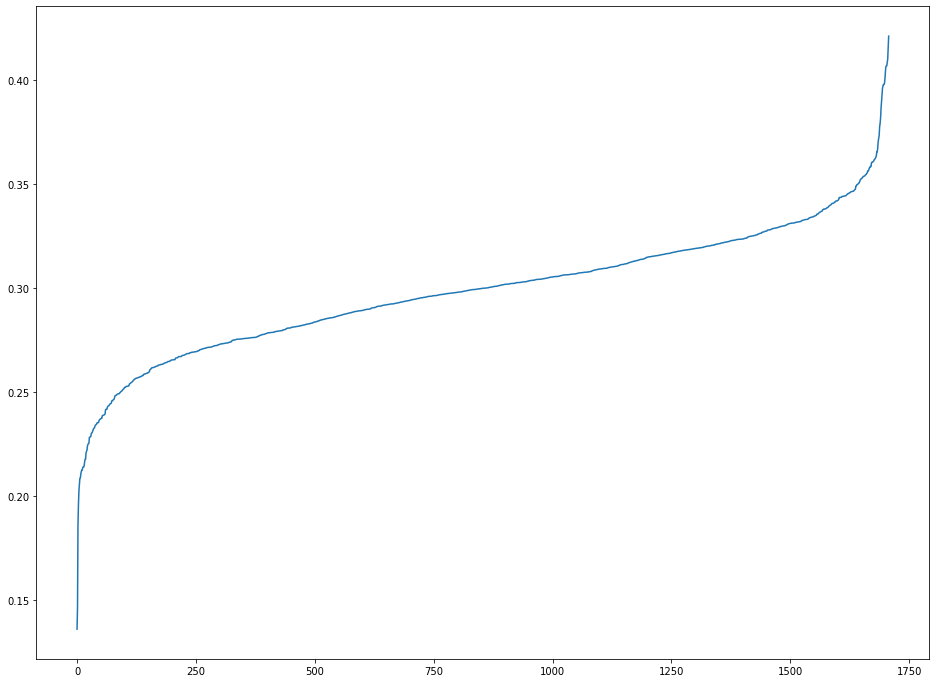

In [153]:
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots()
ax.plot(range(len(neighbours)), neighbours)
plt.show()    

Теперь проведем кластеризацию.

27


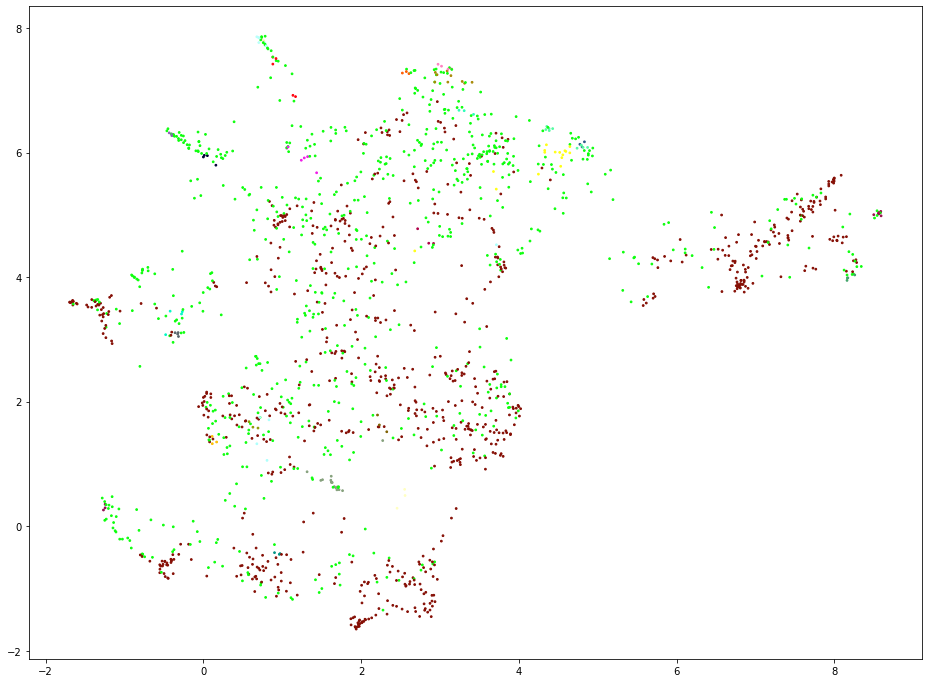

In [170]:
db=DBSCAN(eps=0.17, min_samples=3)
db_clusters=db.fit_predict(w2v_vectors)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [171]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
Раскрыто происхождение новейшей украинской крылатой ракеты
Звезду сериала «Детективы» задержали за работу детектива
С космодрома Восточный запустили третью ракету
1
Социологи подсчитали планирующих проголосовать на выборах-2018
На выборы президента России пойдут почти 80 процентов избирателей
Грудинин уступил в популярности КПРФ
2
Ближний Восток становится центром роскоши
Пользователям заплатят за просмотр порно
Раскрыты подробности нового проекта AliExpress в России
3
Найдены препараты против старения
Опровергнут главный миф об омоложении человека
Найдено предотвращающее старение вещество
4
Неймар заставит «Барселону» расплатиться
Роналду вошел в положение «Реала» и заслужил повышение зарплаты
Щуплость и конкуренция с Гатаговым избавили Неймара от карьеры в России
5
Американская супермодель обвинила соучредителя Guess в домогательствах
Жертва насильника придумала шорты для защиты от насильников
Номинант на «Оскар» заставил поклонников люкса предаться размышлениям
6
В сети появились 

Теперь вернемся к научным статьям.

При объединении всех векторов текста происходит размытие его смысла за счет того, что некоторые понятия хоть и являются близкими, но имеют различия. Вместо того, чтобы брать само слово, давайте объединим все слова одной группы и будем брать их центроид. Заодно посмотрим какие слова попадают в одну группу.

In [172]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 29.8 s, sys: 117 ms, total: 29.9 s
Wall time: 30 s


In [173]:
%%time
dct = {}
# Бежим по статьям.
for article in sci_texts.NText:
    # Берем слово. Потом берем 4 соседа слева и справа.
    words = article.split(' ')
    for i, word1 in enumerate(words[4:-5]):
        for j, word2 in enumerate(words[i-4:i+4]):
            if i!=j:
                # Если основного слова еще не встречалось - добавляем его.
                if word1 not in dct.keys():
                    dct[word1] = {}
                cdict = dct[word1]
                # Говорим, что эти два слова еще раз встретились вместе.
                cdict[word2] = cdict.get(word2, 0) +1


CPU times: user 47.6 s, sys: 477 ms, total: 48.1 s
Wall time: 48.2 s


In [174]:
# Возьмем слова, которые встречаются больше чем с 10 другими словами, каждое из которых встречается чаще 5 раз.
fd = {w:{k:np.log10(i) for k,i in dct[w].items() if i>5} for w in dct.keys() 
      if len([dct[w][k] for k in dct[w] if dct[w][k]>5])>10}

In [180]:
# Берем вектора слов.
sci_vects = []
sci_words = []
for word in fd.keys():
    try:
        sci_vects.append(model_w2v[word])
        sci_words.append(word)
    except Exception:
        pass

In [181]:
word

'хромченко_NOUN'

In [182]:
# Посмотрим как вообще слова распределены в пространстве.
sci_map = UMAP()
sci_reduced = sci_map.fit_transform(sci_vects)

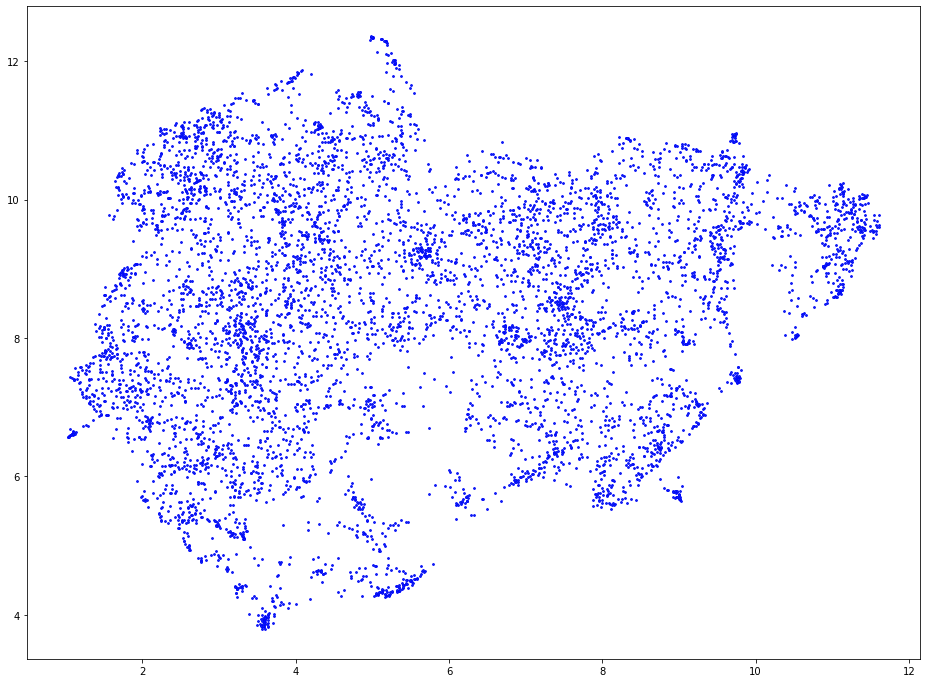

In [183]:
fig, ax = plt.subplots()
ax.scatter(sci_reduced[:, 0], sci_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=3)
plt.show()

In [184]:
%%time
# Кластеризуем, в среднем по два слова на кластер.
sci_clust_no = int(len(sci_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 22min 55s, sys: 13min 5s, total: 36min
Wall time: 6min 4s


In [194]:
# Какие слова попадают в один кластер.
clust_no=10

sci_words_sorted = sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])
print([word[1] for word in sci_words_sorted if word[0]==clust_no])

['натрий_NOUN', 'гидроксид_NOUN', 'фосфат_NOUN', 'нитрат_NOUN', 'нитрит_NOUN', 'сульфат_NOUN', 'хлорид_NOUN', 'гидрат_NOUN', 'аммоний_NOUN', 'карбонат_NOUN', 'барий_NOUN', 'силикат_NOUN']


In [197]:
# Посчитаем координаты центроидов.
cur_clust = sci_words_sorted[0][0]
cur_coord = np.array(model_w2v[sci_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(sci_words_sorted[1:]):
    if cur_clust == sci_words_sorted[i+1][0]:
        cur_coord += model_w2v[sci_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = sci_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[sci_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)


In [231]:
# Эта функция берет центры кластеров вместо слов.
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_vec_centr(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in sci_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[sci_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


In [232]:
# Строим вектора для слов.
sci_vect2 = []
for text in tqdm(sci_texts.Text):
    sci_vect2.append(text_to_vec_centr(text))

In [233]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect2)

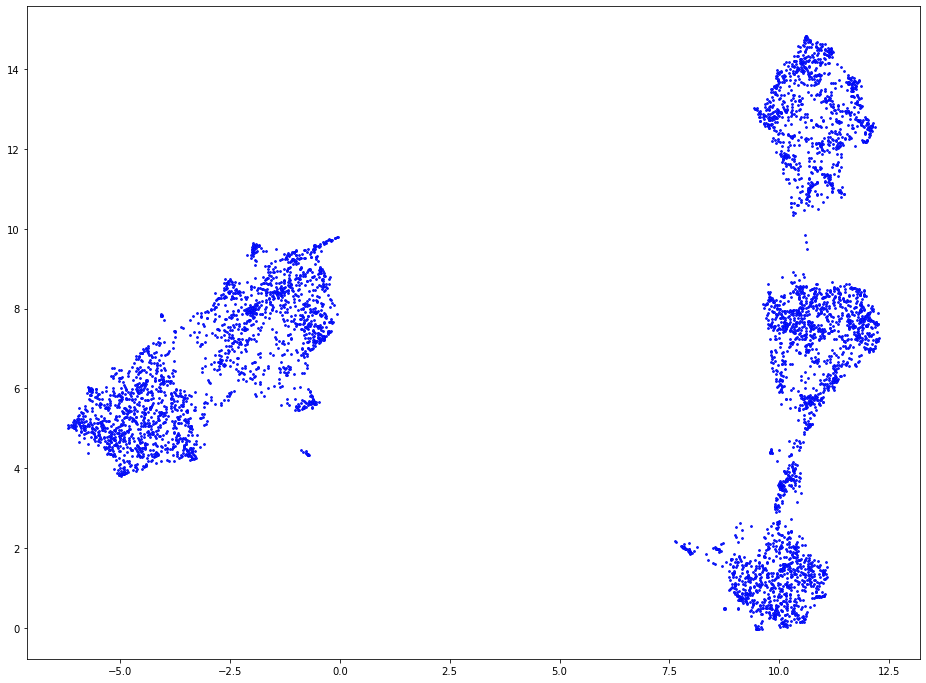

In [234]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

57


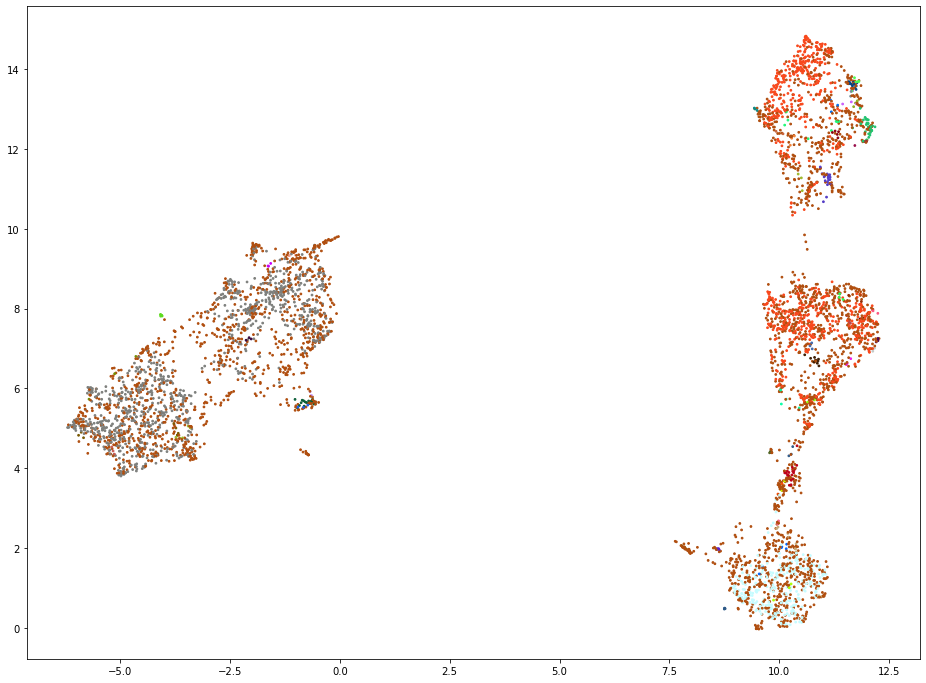

In [241]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.08, min_samples=3)
db_clusters=db.fit_predict(sci_vect2)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [242]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters:
    print('          __ ', c, ' __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

          __  0  __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.в. данилова                сыр, благодаря ег
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
          __  1  __
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                формирование вертикально-интегрированных образован
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                формир

А теперь поступим по-другому. Разделим слова на 50 кластеров, а в качестве вектора признаков документа будем брать число слов данного документа, попадающих в каждый кластер.

In [243]:
%%time
cluster_space_size = 50
km_clustering = KMeans(n_clusters=cluster_space_size)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 33.9 s, sys: 25 s, total: 59 s
Wall time: 9.65 s


In [244]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for sent in normalizePymorphy(text):
        for word in sent:
            if word in sci_words_d.keys():
                n_words = n_words + 1
                text_vec[clust_coord[sci_words_d[word]]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [245]:
clust_coord[sci_words_d['процесс_NOUN']]

array([ 4.04470e-02, -3.98800e-03,  1.11400e-03, -1.56500e-03,
        6.45370e-02, -7.96240e-02,  4.66350e-02, -3.29250e-02,
       -1.41430e-02,  8.69380e-02, -4.67300e-03, -5.26580e-02,
        1.37880e-02, -2.86750e-02, -5.35310e-02, -5.29950e-02,
        1.44490e-02, -7.23880e-02, -1.25670e-02, -5.48660e-02,
        5.29610e-02, -1.05060e-02,  2.49140e-02, -9.88500e-03,
       -1.52450e-02,  4.15680e-02,  5.18310e-02,  3.45090e-02,
       -7.86200e-03, -6.38200e-03, -8.40150e-02,  4.57990e-02,
       -2.89400e-03, -4.24810e-02,  1.44500e-02, -8.44400e-03,
       -9.77600e-03, -8.53950e-02, -1.62200e-02, -9.32930e-02,
        6.92100e-02, -1.57870e-02, -8.50000e-02, -3.09930e-02,
       -3.46800e-02, -7.84510e-02,  4.50060e-02, -2.52400e-02,
        8.62420e-02,  3.34210e-02,  5.05370e-02, -1.82630e-02,
       -7.30700e-03, -1.26520e-02, -2.34500e-03, -4.64850e-02,
        1.27570e-02,  2.96980e-02,  6.03150e-02, -1.21400e-02,
       -7.64200e-03, -9.79990e-02,  3.94980e-02, -2.060

In [246]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in sci_words_d.keys():
            text_vec[sci_words_d[word]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [247]:
# Строим вектора для слов.
sci_vect3 = []
for text in tqdm(sci_texts.NText):
    sci_vect3.append(text_to_centoids(text))

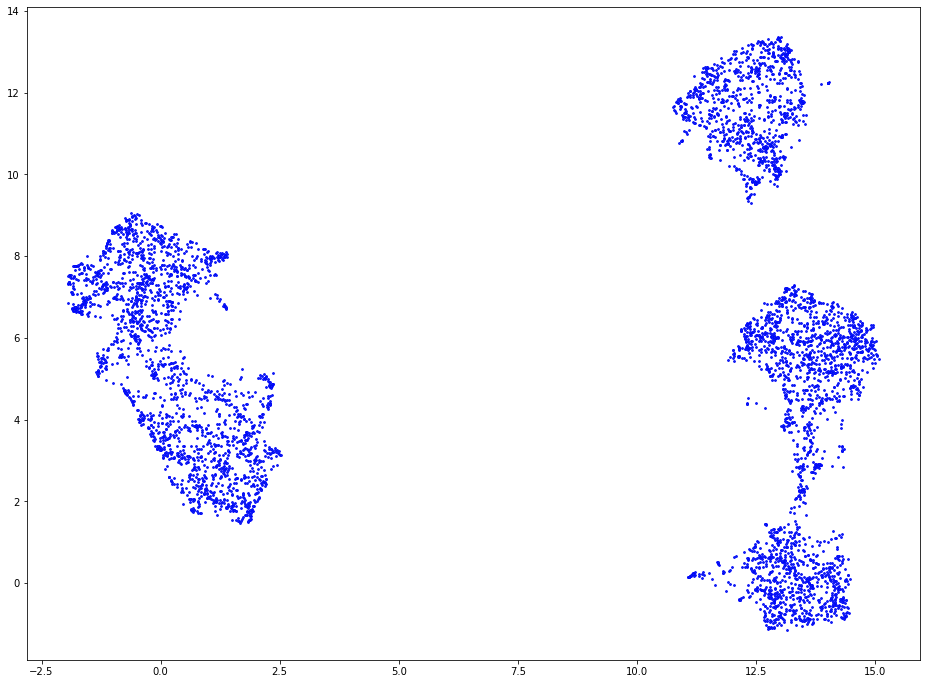

In [248]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect3)

fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

67


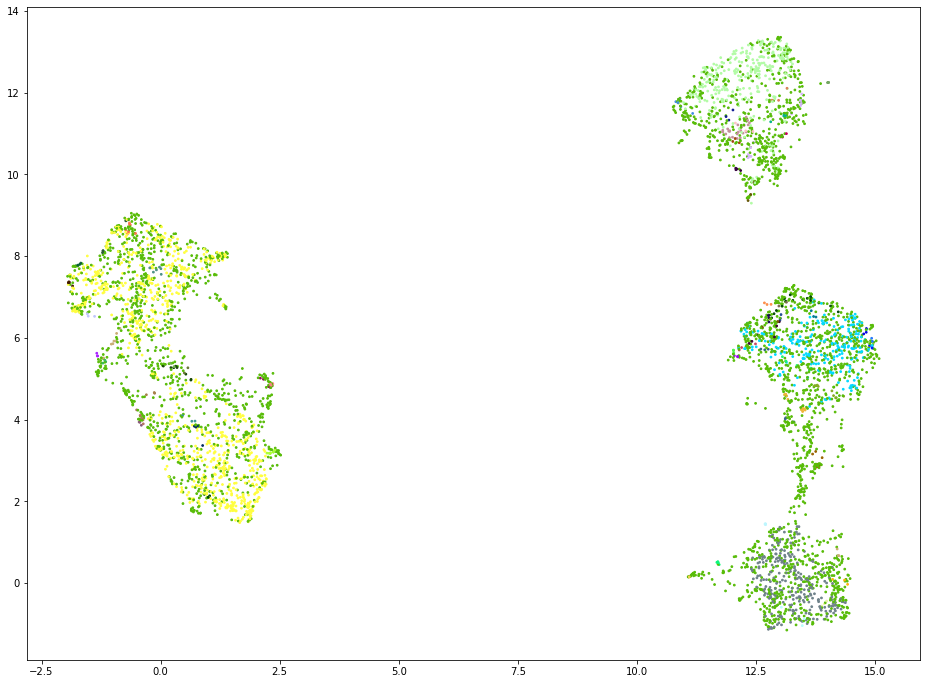

In [249]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.075, min_samples=3)
db_clusters=db.fit_predict(sci_vect3)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [250]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters:
    print(f'__ {c} __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

__ 0 __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.в. данилова                сыр, благодаря ег
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
__ 1 __
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                формирование вертикально-интегрированных образован
                                               ﻿отраслевые рынки и рыночная инфраструктура                удк 338.3.01: 338.439:336.01                формирование вертикально-интег

-----

А теперь посмотрим на FastText.

In [50]:
from gensim.models.fasttext import FastText

In [51]:
#model_ft = KeyedVectors.load_fasttext_format('data/araneum_none_fasttextskipgram_300_5_2018.tgz', binary=True)

#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')


In [52]:
tmp_dict2 = {} # Кеш значимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    output = []
    # Делим на предложения самым страшным из возможных образов.
    sentences = text.split('.')
    for sentence in sentences:
        tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', sentence)
        # Берем предложения не менее чем из 5 слов.
        if len(tokens)<=4:
            continue
        words = []
        for t in tokens:
            # Если токен уже был закеширован, быстро возьмем результат из него.
            if t in tmp_dict2.keys():
                words.append(tmp_dict2[t])
            # Слово еще не встретилось, будем проводить медленный морфологический анализ.
            else:
                pv = morph.parse(t)
                if pv[0].tag.POS != None:
                    # Отправляем слово в результат, ...
                    words.append(pv[0].normal_form)
                    # ... и кешируем результат его разбора.
                    tmp_dict2[t] = pv[0].normal_form
        output.append(words)
                    
    return output

In [55]:
all_sentences = []
for text in tqdm(news.News):
    all_sentences.extend(normalizePymorphy3(text))

In [ ]:
%%time
# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели


model_ft = FastText(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

In [ ]:
model_ft.init_sims(replace=True)

In [ ]:
model_ft.save("data/fast_text_news.bin")

In [ ]:
model_ft = FastText.load("data/fast_text_news.bin")
#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')
# Мне не хватило 16 Гб оперативной памяти, чтобы загрузить эту модель.
#model_ft = FastText.load_fasttext_format("data/cc.ru.300.bin.gz")

In [ ]:
model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']- model_ft.wv['королева_']


In [ ]:
from gensim.models import KeyedVectors # Семантические вектора.


In [ ]:
#model_ft.wv.most_similar(positive=[u'пожар'])
#model_ft.wv.most_similar(positive=[u'пожар'], negative=[u'пламя'])
#model_ft.wv.most_similar(positive=[u'топливо_'], negative=[u'нефть_'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_'])
#model_ft.most_similar(positive=[u'король', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(positive=[u'президент', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(negative=[u'король', u'мужчина'], positive=[u'женщина'])
#model_ft.most_similar(positive=[u'женщина_', u'король_'])
#model_ft.most_similar(positive=['германия_', 'москва_' ], negative=['берлин_'])
print(model_ft.wv.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_']), "\n\n",
model_ft.wv.most_similar([model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']]))

### Что осталось за кадром?

- BERT (+ DeepPavlov)
- Онтологии.
- graph2vec (последовательность прослушанных песен, просмотр товаров, ...).